### Importing Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import callbacks
import re
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing 

import random
from keras.models import load_model
np.random.seed(7)
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install googletrans

In [ ]:
from googletrans import Translator

### Function for converting  English to Hindi 

In [ ]:
def engToHindi(filename,start):
    dff = pd.read_excel(filename, header=0)
    translator = Translator()
    for i,j in dff.iterrows():
            if(i>=start and i<=start+100):
                str1=(j['Review'].split(' '))
                pos=random.randrange(0,len(str1))
                t=translator.translate(str1[pos],dest='hi')
                str1[pos]=t.text;
                str2=" ".join(str1)
                dff.at[i,'Review']=str2
    header=["Review","sentiment"]
    dff.to_excel("predict1.xlsx", index = False, columns = header)
engToHindi("predict.xlsx",601)

### Function for converting Hindi to English

In [ ]:
def hindiToEng(filename,start):
    dff = pd.read_excel(filename, header=0)
    translator = Translator()
    for i,j in dff.iterrows():
            if(i>=start and i<=start+100):
                str1=(j['Review'])
                t=translator.translate(str1,src='hi',dest='en')
                str1=t.text;
                dff.at[i,'Review']=str1
    header=["Review","sentiment"]
#     file="./";
#     file+=filename
#     dff.to_csv(file,sep = '\t',index=False,columns=header)
    dff.to_excel(filename, index = False, columns = header)
hindiToEng("English dataset.xlsx",601)

### Loading the dataset

In [ ]:
# Converting the training dataset to english words
for i in range(4):
    hindiToEng("/content/drive/My Drive/dataset/Hindi dataset.xlsx",(i+3)*100)
    time.sleep(90)

IllegalCharacterError: ignored

In [ ]:
df = pd.read_csv("IMDB Dataset.csv", header=0)
y = df.pop('sentiment')
X = df
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
for i,j in X_train.iterrows():
    if(i==0):
        print(j['Review'])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

### Cleaning the data

In [ ]:
def clean_phrase(phrase):
    #Remove punctuation (with a regular expression) and convert to lower case
    words = (re.sub("[^a-zA-Z]", " ", phrase)).lower()
    return words

In [ ]:
# run preprocessing function on train dataset
clean_phrases = []

for x in X_train['Review']:
    new = clean_phrase(x)
    clean_phrases.append(new)
    
# run preprocessing function  on test dataset
test_clean_phrases = []

for xw in X_test['Review']:
    new_test = clean_phrase(xw)
    test_clean_phrases.append(new_test)

### Tokenizing and converting text to integers

In [ ]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(clean_phrases)
X = tokenizer.texts_to_sequences(clean_phrases)

tokenizer1 = Tokenizer(num_words=max_features, split=' ')
tokenizer1.fit_on_texts(test_clean_phrases)
Y = tokenizer1.texts_to_sequences(test_clean_phrases)

In [ ]:
X_train = sequence.pad_sequences(X, maxlen=600)
X_test = sequence.pad_sequences(Y, maxlen=600)
print(X_train.shape)
print(X_test.shape)

(40000, 600)
(10000, 600)


### LabelEncoding

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(['negative','positive'])
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
y_test

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
X_test

array([[   0,    0,    0, ...,    6, 6473, 1115],
       [   0,    0,    0, ..., 3073,    2, 1496],
       [   0,    0,    0, ..., 2289,    7,    7],
       ...,
       [   0,    0,    0, ...,   18,    1,  378],
       [   0,    0,    0, ...,  149,  120,  307],
       [   0,    0,    0, ...,  267,  141,  824]])

In [ ]:
cbks = [callbacks.ModelCheckpoint(filepath='./model.h5', monitor='val_loss', save_best_only=True),
            callbacks.EarlyStopping(monitor='val_loss', patience=2),callbacks.TensorBoard(log_dir='.\logs', histogram_freq=0, write_graph=True, write_images=False,profile_batch = 40000)]

### Creating and training the model

In [ ]:
# create the model
top_words = 10000
embedding_vecor_length = 32
max_review_length = 600
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# filepath="weights_best_cnn.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
# callbacks_list = [checkpoint]
model.fit(X_train, y_train, epochs=5, batch_size=256,verbose = 1,callbacks = cbks,validation_split=0.2)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 600, 32)           320000    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 600, 32)           3104      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 300, 32)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 34

In [ ]:
model = load_model('model.h5')
test_pred = model.predict_classes(X_train)
print(test_pred)

[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


In [ ]:
from matplotlib.colors import ListedColormap
y = list(y_test)
pred = list(test_pred)

In [ ]:
# print((y))
x = [0,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1]
print(type(y))

<class 'list'>


In [ ]:
for i in range(len(y)):
    if( y[i] == 2):
        y[i] = 0.5

In [ ]:
y

[0.5,
 1,
 1,
 0.5,
 1,
 0.5,
 0.5,
 1,
 1,
 1,
 1,
 1,
 0.5,
 1,
 0.5,
 1,
 1,
 0.5,
 0.5,
 0.5,
 1,
 1,
 0.5,
 0.5,
 1,
 1,
 0.5,
 1,
 1,
 1,
 0.5,
 0.5,
 0.5,
 1,
 1,
 1,
 0.5,
 1,
 1,
 1,
 0.5,
 0.5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.5,
 1,
 0.5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.5,
 1,
 1,
 1,
 1,
 1,
 1,
 0.5,
 1,
 0.5,
 1,
 1,
 0.5,
 1,
 0.5,
 1,
 0.5,
 1,
 1,
 1,
 1,
 1,
 0.5,
 0.5,
 0.5,
 1,
 1,
 1,
 1,
 0.5,
 0.5,
 1,
 0.5,
 0.5,
 0.5,
 1,
 0.5,
 1,
 1,
 1,
 0.5,
 1,
 0.5,
 0.5,
 0.5,
 1,
 1,
 1,
 1,
 0.5,
 0.5,
 1,
 0.5,
 1,
 0.5,
 1,
 1,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 1,
 1,
 0.5,
 0.5,
 0.5,
 0.5,
 1,
 1,
 0.5,
 0.5,
 1,
 0.5,
 1,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 1,
 1,
 1,
 1,
 0.5,
 1,
 0.5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.5,
 1,
 0.5,
 1,
 0.5,
 1,
 1,
 1,
 0.5,
 1,
 1,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 1,
 0.5,
 0.5,
 1,
 0.5,
 0.5,
 0.5,
 1,
 1,
 0.5,
 1,
 0.5,
 0.5,
 0.5,
 0.5,
 1,
 1,
 1,
 0.5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.5,
 1,
 1,
 1,
 0.5,
 0.5,
 1,
 0.5,
 0.5,
 0.5

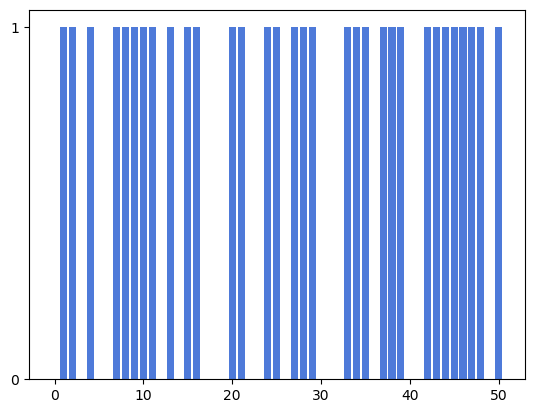

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

# objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
# y_pos = np.arange(len(objects))
p = [i for i in range(0,51)]
plt.yticks(np.arange(-5, max(p)+1, 1.0))
plt.bar(p, y[0:51], align='center',color='b', alpha=0.5)
plt.bar(p, y[0:51], align='center', alpha=0.5)

# plt.xticks(y_pos, objects)
# plt.ylabel('Usage')
# plt.title('Programming language usage')

plt.show()

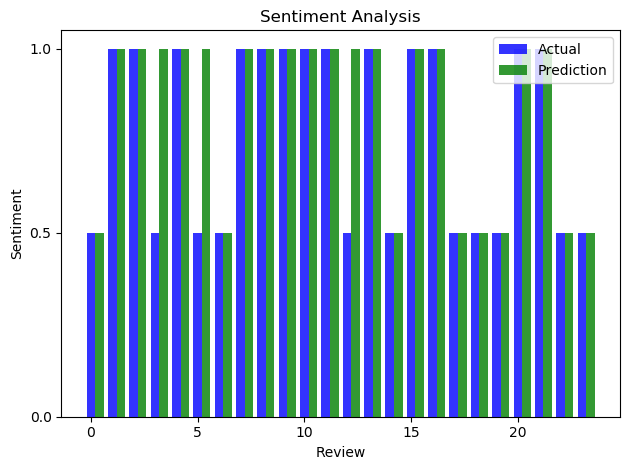

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 24
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)
x = [0.5,1,1,1,1,1,0.5,1,1,1,1,1,1,1,0.5,1,1,0.5,0.5,0.5,1,1,0.5,0.5,0.5]


# create plot
# fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
plt.yticks(np.arange(-5, max(p)+1, 0.5))


rects1 = plt.bar(index, y[0:24], bar_width,
alpha=opacity,
color='b',
label='Actual')

rects2 = plt.bar(index + bar_width,x[0:24], bar_width,
alpha=opacity,
color='g',
label='Prediction')


plt.xlabel('Review')
plt.ylabel('Sentiment')
plt.title('Sentiment Analysis')
# plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_train

array([1, 0, 0, ..., 1, 0, 1])

In [ ]:
X_train1 = X_train

In [ ]:
dff = pd.read_excel("Training-result.xlsx", header=0)
dff = X_train1
dff['Sentiment'] = test_pred.reshape(-1,1)
print(dff)
header=["Review","Sentiment"]
dff.to_excel("Training-result.xlsx", index = False, columns = header)


                                                  Review  Sentiment
0      This is how movies are supposed to be made: a ...          1
1      it was a very well written movie, and the acto...          0
2      The acting in this film was of the old school:...          1
3      MGM hodgepodge of Jimmy Durante throwing a big...          0
4      My ex wife and I saw and were intrigued by the...          1
...                                                  ...        ...
39995  I don't know who to blame, the timid writers o...          0
39996  Many people remember the Waco standoff that oc...          0
39997  Okay, I know that's cliché. Taken on its surfa...          0
39998  Brilliant. Ranks along with Citizen Kane, The ...          1
39999  as a fan of robocop, i always loved this movie...          1

[40000 rows x 2 columns]


### Evaluating the model

In [ ]:
# Final evaluation of the model
# create the model
top_words = 10000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.load_weights("model.h5")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           320000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 600, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 300, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 88.09%


In [ ]:
table = PrettyTable()
table.field_names = ['Model', 'Accuracy']
table.add_row(['CNN using LSTM training', 94.30])
table.add_row(['CNN using LSTM test data', 88.09])
print(table)

+--------------------------+----------+
|          Model           | Accuracy |
+--------------------------+----------+
| CNN using LSTM training  |   94.3   |
| CNN using LSTM test data |  88.09   |
+--------------------------+----------+


In [ ]:
def preProcessing(file):
    phrases = hindiToEng(file)
    features = 10000
    tokenizer = Tokenizer(num_words=features, split=' ')
    tokenizer.fit_on_texts(phrases)
    X_tokens = tokenizer.texts_to_sequences(phrases)
    data = sequence.pad_sequences(X_tokens, maxlen=600)
    return data

In [ ]:
def classify(file):
    data = preProcessing(file)
    embedding_vecor_length = 32
    top_words = 10000
    max_review_length = 600
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.load_weights("model.h5")
    pred = (model.predict_classes(data))
    dframe = pd.read_excel(file, header=0)
    dframe['Sentiment'] = pred.reshape(-1,1)
    header=["Review","Sentiment"]
    dframe.to_excel("Result.xlsx", index = False, columns = header)
    print(pred)
classify("Predict-Hindi.xlsx")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           320000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 600, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 300, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________
None
[[1]
 [1]
 [1]
 [0]]


In [ ]:
def engToHindi(filename):
    dff = pd.read_excel(filename, header=0)
    translator = Translator()
    for i,j in dff.iterrows():
                str1=(j['Review'].split(' '))
                pos=random.randrange(0,len(str1))
                t=translator.translate(str1[pos],dest='hi')
                str1[pos]=t.text;
                str2=" ".join(str1)
                dff.at[i,'Review']=str2
    header=["Review"]
    dff.to_excel(".xlsx", index = False, columns = header)
engToHindi(".xlsx")

In [ ]:
def hindiToEng(filename):
    dff = pd.read_excel(filename, header=0)
    data = []
    translator = Translator()
    for i,j in dff.iterrows():
                str1=(j['Review'])
                t=translator.translate(str1,src='hi',dest='en')
                str1=t.text;
                data.append(str1)
    return data
